# CEIA -NLP - Desafío 3 - Modelo de lenguaje

16Co2024 - Myrna Lorena Degano - a1618

In [79]:
import urllib.request
import re
import pickle
import gc

import seaborn as sns
import numpy as np
import bs4 as bs
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K

from collections import Counter
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, TimeDistributed, CategoryEncoding, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.optimizers import RMSprop



**Consigna**
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


*Sugerencias*
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

### Conjunto de datos

Tomo como corpus para el desafío el cuento "El Gato Negro" de Edgar Allan Poe.

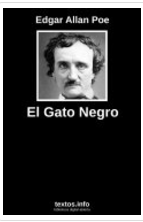

Con este mismo corpus, voy a explorar diferentes modelos de lenguaje por palabras.

In [80]:
raw_html = urllib.request.urlopen('https://www.textos.info/edgar-allan-poe/el-gato-negro/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()


In [81]:
# en article text se encuentra el texto de todo el libro
article_text

' no espero ni solicito fe para la narración tan sencilla como\r\nextravagante que está a punto de brotar de mi pluma. locura sería en\r\nverdad el esperarlo, pues que mis propios sentidos rechazan su\r\nevidencia. sin embargo, no estoy loco, ni estoy soñando, de seguro. mas\r\ndebo morir mañana y quiero hoy aligerar el peso de mi alma. mi propósito\r\ninmediato es presentar llana y sucintamente a los ojos del lector, sin\r\ncomentario de ninguna clase, una serie de simples acontecimientos\r\ndomésticos. en sus consecuencias, estos acontecimientos me han\r\naterrorizado, me han torturado, me han deshecho. a pesar de todo, no\r\ntrataré de interpretarlos. para mí sólo han representado el horror; para\r\nmuchos otros serán quizá no tanto terribles como baroques. es posible\r\nque se encuentre después algún entendimiento que reduzca mi fantasma a\r\nlos límites de lo vulgar; algún entendimiento más sereno, más lógico y\r\nmucho menos excitable que el mío, capaz de percibir en las\r\ncircu

### Elección del tamaño del contexto

* Para el modelo de lenguaje por palabras:  

In [82]:
# Separar el corpus en documentos por CRLF
df = pd.DataFrame(article_text.split('\r\n'), columns=['text'])

print(df.head())
print("\nCantidad de documentos:", df.shape[0])

                                                text
0   no espero ni solicito fe para la narración ta...
1  extravagante que está a punto de brotar de mi ...
2  verdad el esperarlo, pues que mis propios sent...
3  evidencia. sin embargo, no estoy loco, ni esto...
4  debo morir mañana y quiero hoy aligerar el pes...

Cantidad de documentos: 299


In [83]:
# Guardar cada documento en una lista
text = list(df['text'])

# Segmentar cada documento en palabras
segmented_sentences_df = [text_to_word_sequence(sentence) for sentence in text]


In [84]:
# Ejemplo
segmented_sentences_df[0]

['no',
 'espero',
 'ni',
 'solicito',
 'fe',
 'para',
 'la',
 'narración',
 'tan',
 'sencilla',
 'como']

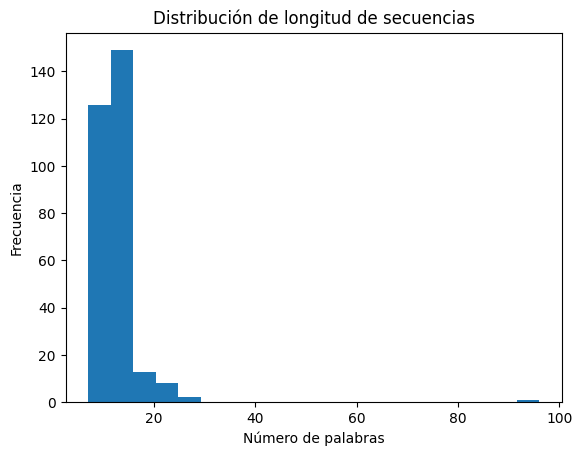

In [85]:
# Longitud de cada secuencia
length_sentences_df = [len(sentence) for sentence in segmented_sentences_df]

# Histograma - Distribución de tamaño de secuencias
plt.hist(length_sentences_df, bins=20)
plt.title('Distribución de longitud de secuencias')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

In [86]:
# Diferentes tamaños de contexto máximo basados en la longitud de las secuencias:

max_context_size_word_1 = int(np.percentile(length_sentences_df, 90)-1) # percentil
max_context_size_word_2 = int(np.ceil(np.mean(length_sentences_df))) # media
max_context_size_word_3 = int(np.ceil(np.median(length_sentences_df))) # mediana

print(f'max_context_size (words): {max_context_size_word_1} | {max_context_size_word_2} | {max_context_size_word_3}')



max_context_size (words): 14 | 13 | 12


* **Percentil 90 menos 1** (max_context_size_word_1):  
Da la longitud de la secuencia en el percentil 90 y le resta 1.   
La idea es capturar la mayoría de las oraciones más largas, excluyendo los valores extremos más altos (los outliers).  

* **Media (redondeada hacia arriba)** (max_context_size_word_2):  
Calcula la longitud promedio de las oraciones y se redondea hacia arriba.   
La media puede ser sensible a oraciones extremadamente largas o cortas, por lo que en presencia de outliers, podría no reflejar de forma precisa el tamaño típico de las oraciones.

* **Mediana (redondeada hacia arriba)** (max_context_size_word_3):  
La mediana es el valor central en el conjunto de datos. Al redondearla hacia arriba, resulta en un número entero, que representa la tendencia central de las longitudes de las oraciones.

Dado que las tres medidas son bastante cercanas tomo como max_context_size_word el valor máximo:

In [87]:
max_context_size = max([max_context_size_word_1, max_context_size_word_2, max_context_size_word_3])
print(max_context_size)

14


### Tokenización

In [88]:
# Tokenizar por palabras
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences_df)
# Convertir palabras a números
tokenized_sentences_df = tok.texts_to_sequences(segmented_sentences_df)

In [89]:
# Cantidad de palabras en el vocabulario
print(f'Tamaño del vocabulario: {len(tok.word_counts)} palabras.')

vocab_words_size = len(tok.word_counts)

Tamaño del vocabulario: 1441 palabras.


In [90]:
# Obtener las palabras y sus índices (palabra -> índice)
word_index = tok.word_index
print(f"Vocabulario: {word_index}")

Vocabulario: {'de': 1, 'y': 2, 'la': 3, 'que': 4, 'el': 5, 'mi': 6, 'en': 7, 'a': 8, 'me': 9, 'por': 10, 'se': 11, 'un': 12, 'los': 13, 'no': 14, 'del': 15, 'al': 16, 'con': 17, 'una': 18, 'lo': 19, 'su': 20, 'había': 21, 'más': 22, 'como': 23, 'mis': 24, 'era': 25, 'las': 26, 'para': 27, 'sin': 28, 'animal': 29, 'gato': 30, 'casa': 31, 'esta': 32, 'este': 33, 'es': 34, 'mí': 35, 'hasta': 36, 'día': 37, 'pero': 38, 'cuando': 39, 'sobre': 40, 'ni': 41, 'mujer': 42, 'uno': 43, 'corazón': 44, 'e': 45, 'yo': 46, 'alma': 47, 'gran': 48, 'parte': 49, 'si': 50, 'o': 51, 'fin': 52, 'noche': 53, 'terror': 54, 'ser': 55, 'tan': 56, 'embargo': 57, 'estoy': 58, 'mas': 59, 'sus': 60, 'horror': 61, 'aun': 62, 'sentimiento': 63, 'razón': 64, 'plutón': 65, 'semejante': 66, 'muy': 67, 'entonces': 68, 'muro': 69, 'casi': 70, 'sido': 71, 'ojos': 72, 'han': 73, 'después': 74, 'tiempo': 75, 'apenas': 76, 'aquel': 77, 'tenía': 78, 'así': 79, 'le': 80, 'dentro': 81, 'mano': 82, 'momento': 83, 'cuerpo': 84, '

### Separación del dataset


 Separo la porción de texto utilizada en entrenamiento de la de validación (20%).

In [91]:
# Proporción del corpus que se reservará para validación
p_val = 0.2

In [92]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences_df,
                                                                            tokenized_sentences_df,
                                                                            test_size=p_val,
                                                                            random_state=42)



In [93]:
tok_sent= []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armar varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):

    extra = len(sent)-(max_context_size+1) + 1

    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])

  else:
    # si la secuencia tiene menos términos el tamaño de contexto máximo, queda como está
    tok_sent.append(sent)


In [94]:
tok_sent_augm = []

for sent in tok_sent:

  # Generar sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]

  # Padding al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [95]:
# Concatenar todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

# Entradas y targets para el entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

print(X.shape)
print(y.shape)

(5424, 14)
(5424, 14)


### Arquitectura del modelo


In [96]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, n_exp, patience=10):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []
      self.n_exp = n_exp

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"model_{self.n_exp}.keras")
          print("Saved new model!\n")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

In [97]:
print(vocab_words_size)
print(f'Raíz cuadrada del tamaño del vocabulario: {vocab_words_size ** 0.5}')
print(f'Raíz cuarta del tamaño del vocabulario: {vocab_words_size ** 0.25}')

1441
Raíz cuadrada del tamaño del vocabulario: 37.960505792204614
Raíz cuarta del tamaño del vocabulario: 6.161209766937384


In [98]:
# Tamaño del embedding
embedding_size = 40

# Nro. de neuronas x capa
n_neurons_1 = 128
n_neurons_2 = 64

# DropOut
p_dropout = 0.2

#### Arquitectura A - LSTM

* Modelo de red neuronal utilizando LSTM (Long Short-Term Memory).  

 1) Embedding Layer: Los índices de las palabras en la secuencia de entrada se convierten en vectores densos de n dimensiones. Esto permite que el modelo trabaje con representaciones continuas de las palabras, lo que es útil para tareas de PLN.  

 2) LSTM Layers: Estas capas LSTM procesan las secuencias de palabras y aprenden las dependencias temporales en los datos. La primera capa LSTM captura patrones a corto plazo, y la segunda capa LSTM trata de aprender dependencias a largo plazo.  

 3) Dense Layer: La capa final densa genera una predicción para cada token del vocabulario.   
La activación softmax convierte estas predicciones en probabilidades de cada clase.

* SparseCategoricalCrossentropy como función de pérdida (apropiada para clasificación multiclase).

* Optimizador RMSprop

In [99]:
modelA = Sequential()

modelA.add(Input(shape=(None,)))
modelA.add(Embedding(input_dim=vocab_words_size+1, output_dim=embedding_size))
modelA.add(LSTM(n_neurons_1, return_sequences=True))
modelA.add(Dropout(p_dropout))
modelA.add(LSTM(n_neurons_2, return_sequences=True))
modelA.add(Dense(vocab_words_size+1, activation='softmax'))
modelA.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

In [100]:
modelA.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, None, 40)            │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 128)           │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 64)            │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 1442)          │          93,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,346 (1.10 MB)

 Trainable params: 287,346 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura B - GRU

* Embedding Layer: esta capa convierte los índices de las palabras en vectores densos.

* GRU: capa GRU en lugar de LSTM.   
Las redes GRU (Gated Recurrent Units) son más ligeras y a menudo más eficientes que las LSTM al modelar secuencias largas, sin perder demasiada capacidad de modelado.

* Dropout: para evitar sobreajuste.

* Dense Layer: La capa de salida con una activación softmax para clasificación multiclase.

* SparseCategoricalCrossentropy para una clasificación multiclase (índices en lugar de one-hot encoding).

* Optimizador RMSprop

In [101]:
modelB = Sequential()
modelB.add(Input(shape=(None,)))
modelB.add(Embedding(input_dim=vocab_words_size+1, output_dim=embedding_size))
modelB.add(GRU(n_neurons_1, return_sequences=True))
modelB.add(Dropout(p_dropout))
modelB.add(GRU(n_neurons_2, return_sequences=True))
modelB.add(Dense(vocab_words_size+1, activation='softmax'))
modelB.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')



In [102]:
modelB.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 40)            │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, None, 128)           │          65,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, None, 64)            │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 1442)          │          93,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,938 (991.95 KB)

 Trainable params: 253,938 (991.95 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura C - RNN

* Embedding: Las palabras se transforman en vectores densos de longitud embedding_size mediante una capa de Embedding.  

* SimpleRNN: Dos capas de SimpleRNN procesan las secuencias con la opción de devolver secuencias completas (return_sequences=True), lo que permite que la salida de cada capa sea una secuencia de la misma longitud que la entrada.

* Dropout: para prevenir el sobreajuste durante el entrenamiento, eliminando aleatoriamente el 20% de las unidades de la capa.

* Salida: La capa densa final tiene un número de neuronas igual al tamaño del vocabulario, con una función de activación softmax para producir probabilidades sobre las posibles palabras siguientes en la secuencia.

In [103]:
modelC = Sequential()
modelC.add(Input(shape=(None,)))
modelC.add(Embedding(input_dim=vocab_words_size+1, output_dim=embedding_size))
modelC.add(SimpleRNN(n_neurons_1, return_sequences=True))
modelC.add(Dropout(p_dropout))
modelC.add(SimpleRNN(n_neurons_2, return_sequences=True))
modelC.add(Dense(vocab_words_size+1, activation='softmax'))
modelC.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')


In [104]:
modelC.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, None, 40)            │          57,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, None, 128)           │          21,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 1442)          │          93,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,394 (724.20 KB)

 Trainable params: 185,394 (724.20 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [105]:
def graphResults(i, loss, ppl):

  fig, ax1 = plt.subplots(figsize=(10, 5))

  ax1.plot(loss, label='Pérdida de entrenamiento', color='blue')
  ax1.set_xlabel('Época')
  ax1.set_ylabel('Pérdida', color='blue')
  ax1.tick_params(axis='y', labelcolor='blue')
  ax1.legend(loc='upper left')

  ax2 = ax1.twinx()
  ax2.plot(ppl, label='Perplejidad', color='red')
  ax2.set_ylabel('Perplejidad', color='red')
  ax2.tick_params(axis='y', labelcolor='red')
  ax2.legend(loc='upper right')

  plt.title(f'Experimento {i}')

  plt.show()

In [106]:
n_epochs = 25
batch_size = 64
history_ppl_results = {}

#### 1 (A)

In [107]:
history_ppl = []
n_exp = 1

hist_1 = modelA.fit(X, y, epochs=n_epochs,
                    callbacks=[PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, n_exp=n_exp)], batch_size=batch_size)

history_ppl_results[n_exp] = history_ppl



Epoch 1/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 5.9537
 mean perplexity: 2061.6368500633516 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - loss: 5.9415
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.9524
 mean perplexity: 1367.5467733494443 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 3.9516
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 3.5363
 mean perplexity: 1325.1683079885163 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 3.5358
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3.4139
 mean perplexity: 1536.8650248664198 

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 3.4137
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.3818
 mean perplexity: 1634.1748554510712 

85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 3.3817
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 3.3522
 mean perplexity: 1663.2447233627609 

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 1

#### 2 (B)

In [108]:
history_ppl = []
n_exp = 2

hist_2 = modelB.fit(X, y, epochs=n_epochs,
                    callbacks=[PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, n_exp=n_exp)], batch_size=batch_size)

history_ppl_results[n_exp] = history_ppl

Epoch 1/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 5.5869
 mean perplexity: 1936.4903319553966 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - loss: 5.5757
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 3.8065
 mean perplexity: 1328.258328152155 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 3.8048
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.3826
 mean perplexity: 1813.0832992425521 

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 3.3826
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3.3432
 mean perplexity: 1746.5258344185117 

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 3.3427
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 3.1993
 mean perplexity: 2103.2640634769305 

85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 3.1991
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 3.1249
 mean perplexity: 2197.592849209649 

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 

#### 3(C)

In [109]:
history_ppl = []
n_exp = 3

hist_3 = modelC.fit(X, y, epochs=n_epochs,
                    callbacks=[PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, n_exp=n_exp)], batch_size=batch_size)

history_ppl_results[n_exp] = history_ppl

Epoch 1/25
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 5.4878
 mean perplexity: 1803.7777086421816 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 5.4670
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.6085
 mean perplexity: 1463.3687163065695 

Saved new model!

85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 3.6072
Epoch 3/25
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.3495
 mean perplexity: 1658.8590342544348 

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 3.3496
Epoch 4/25
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 3.2802
 mean perplexity: 1606.2377645665356 

85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 3.2795
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.1706
 mean perplexity: 1995.2378291151033 

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 3.1698
Epoch 6/25
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.9727
 mean perplexity: 2328.6423693775264 

85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 2.9721


#### Resultados de entrenamientos

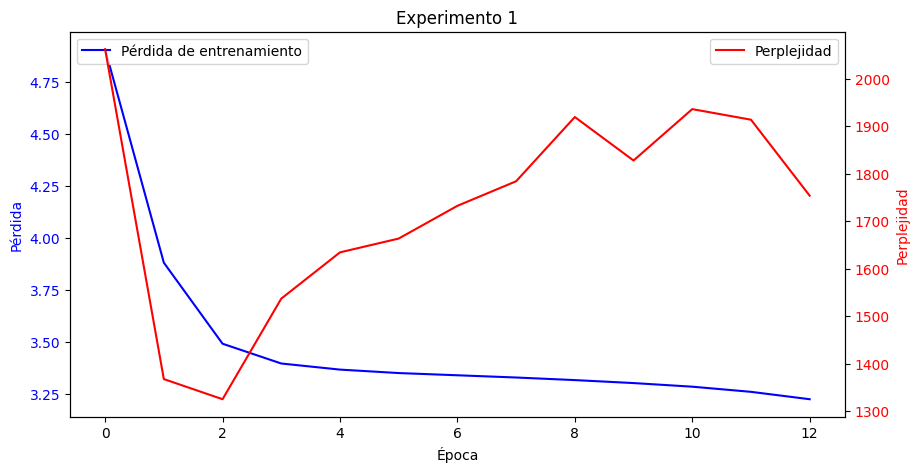

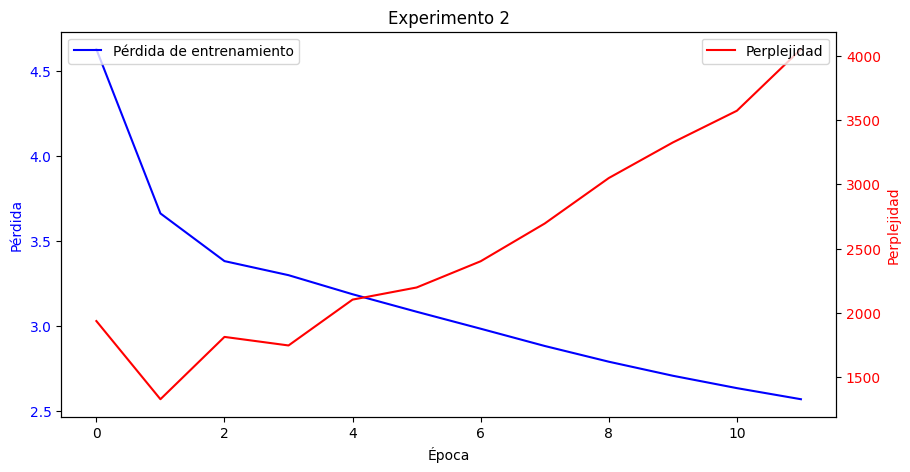

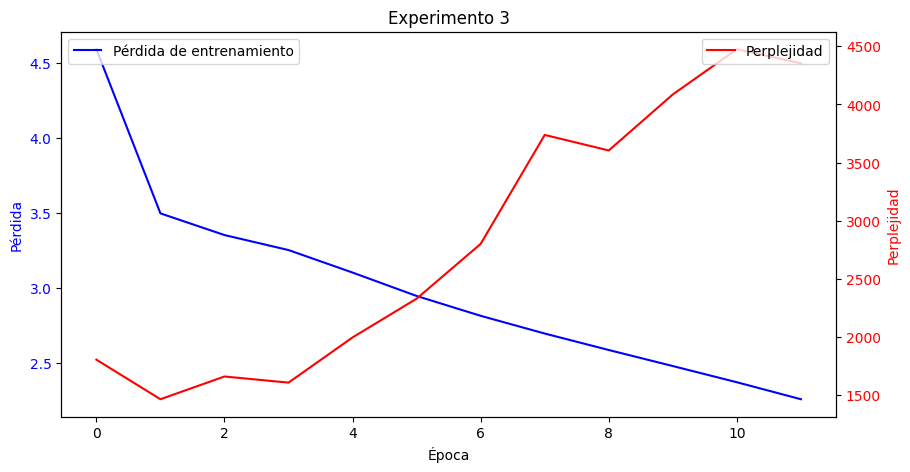

In [110]:
graphResults(1, hist_1.history['loss'], history_ppl_results[1])
graphResults(2, hist_2.history['loss'], history_ppl_results[2])
graphResults(3, hist_3.history['loss'], history_ppl_results[3])

In [111]:
# Tomar valor mínimo de perplejidad por experimento
history_ppl_results_mins = {}
for i, values in history_ppl_results.items():
  history_ppl_results_mins[i] = min(values)

In [112]:
# Ordenar los modelos por mejor resultado de perplejidad
sorted_history_ppl_results = dict(sorted(history_ppl_results_mins.items(), key=lambda item: item[1]))

print(sorted_history_ppl_results)

{1: 1325.1683079885163, 2: 1328.258328152155, 3: 1463.3687163065695}


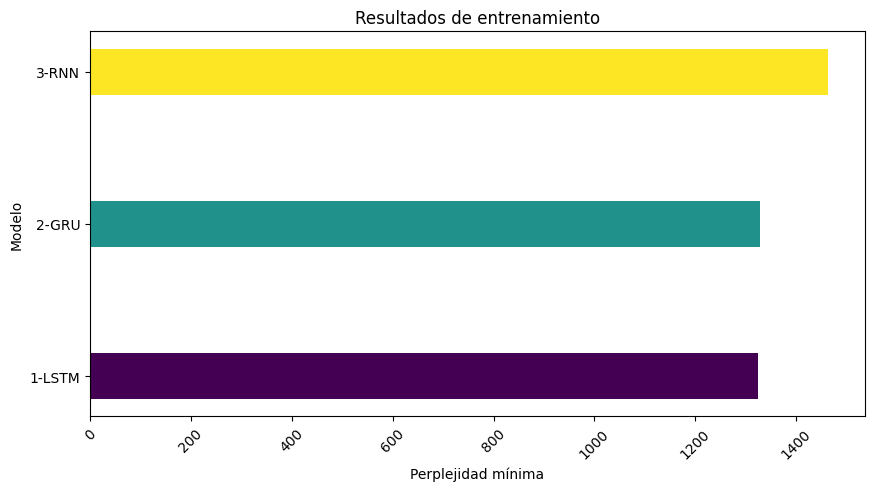

In [113]:
ppls = list(sorted_history_ppl_results.values())
exps = ['1-LSTM', '2-GRU', '3-RNN']

colormap = plt.cm.viridis
colors = colormap(np.linspace(0, 1, len(ppls)))

plt.figure(figsize=(10, 5))
plt.barh(exps, ppls, color=colors, height=0.3)
plt.xlabel('Perplejidad mínima')
plt.ylabel('Modelo')
plt.title(f'Resultados de entrenamiento')
plt.xticks(rotation=45)
plt.show()


### Generación de secuencias

In [114]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

      # Predicción softmax
      preds = model.predict(encoded)

      y_hat = np.argmax(preds[0, -1, :])
      print(f"Índice Predicho: {y_hat}")

      # Vamos concatenando las predicciones
      out_word = ''

      # Buscar la palabra correspondiente en el vocabulario
      out_word = ''
      if y_hat != 0:  # Asegurarse de que no es padding
          for word, index in tokenizer.word_index.items():
              if index == y_hat:
                  out_word = word
                  break

      if out_word == '':
          out_word = '<UNK>'  # Si no se encuentra la palabra

      output_text += ' ' + out_word

    return output_text


In [115]:
# Texto semilla y cantidad de palabras
input_text='gato negro'
n_words = 5

In [116]:
# Cargar modelos para inferencia
model1 = keras.models.load_model('model_1.keras')
model2 = keras.models.load_model('model_2.keras')
model3 = keras.models.load_model('model_3.keras')

models = {
    'LSTM': model1,
    'GRU': model2,
    'RNN': model3
}


In [117]:
for arq, modeln in models.items():

  print(f'\n[{arq}]')
  result = generate_seq(modeln, tok, input_text, max_length=max_context_size, n_words=n_words)
  print()
  print(result)


[LSTM]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Índice Predicho: 1

gato negro de de de de de

[GRU]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Índice Predicho: 1

gato negro de de de de de

[RNN]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Índice Predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Índice Predicho: 1

gato negro de de de de de


Se observa que, en algunos casos, el modelo predice siempre el índice 0, lo que podría significar que no está entrenado correctamente.  Ya sea por falta de datos o entrenamiento insuficiente, si el modelo no ha aprendido bien, puede estar siempre prediciendo la clase 0 como la "más segura".  


En los casos que sí arroja predicciones, se observa que siempre predice la palabra **"de"**.  

De alguna manera, este comportamiento es esperable, ya que, analizando la distribución de las palabras en el texto, "*de*" es la palabra con mayor frecuencia dentro del corpus.

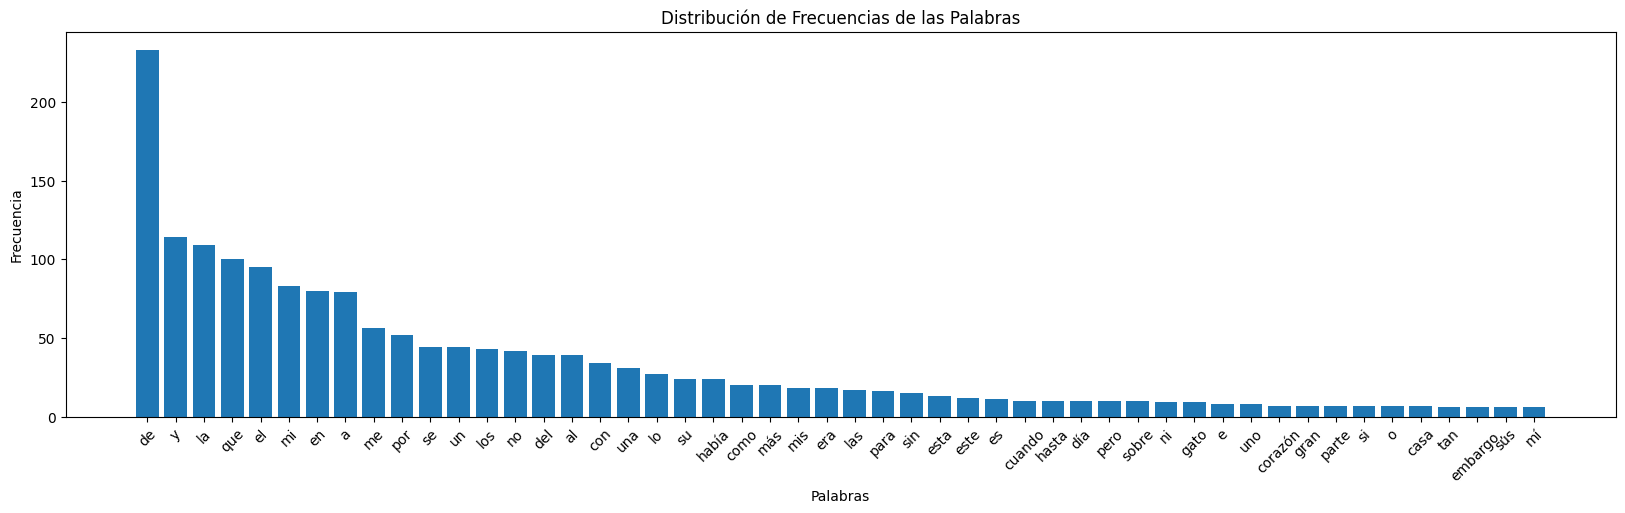

In [118]:
# Obtener las frecuencias de las palabras en el corpus
word_counts = Counter()

for t in text:
  word_counts.update(t.split())

words, counts = zip(*word_counts.most_common())  # Palabras y frecuencias
q_words = 50

plt.figure(figsize=(20, 5))
plt.bar(words[:q_words], counts[:q_words])  # Muestra las 'q_words' palabras más frecuentes
plt.xticks(rotation=45)
plt.title('Distribución de Frecuencias de las Palabras')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

Evalúo Beam Search para poder encontrar las secuencias más probables pero aplicando ciertas restricciones.

In [119]:
def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

In [120]:
def decode(seq):
    return tok.sequences_to_texts([seq])

Beam Search es un tipo de búsqueda en anchura que limita el número de nodos explorados a un número fijo.  

En lugar de explorar todas las posibles secuencias de manera exhaustiva, el algoritmo sólo mantiene un número limitado de secuencias en cada paso, lo que lo hace mucho más eficiente.


In [121]:
# Selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)



In [122]:
def beam_search(model, num_beams, num_words, input, temp=1, mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

La **temperatura** se utiliza para controlar la aleatoriedad en el proceso de selección de la siguiente palabra o token a partir de la distribución de probabilidades generada por el modelo.

En el contexto de tareas de modelado de lenguaje o generación de texto, la salida del modelo es una distribución de probabilidad sobre todas las posibles palabras del vocabulario, y la temperatura ayuda a ajustar esa distribución para hacer que la selección de palabras sea más determinista o más aleatoria.

Exploro diferentes variantes modificando parámetros:

In [123]:
# Predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y 'sto' (estocástico)
# Para el caso estocástico también se puede variar la temperatura

In [124]:
input_text = 'Una noche en que regresaba a casa muy embriagado'

beam_search_options = [
    {'num_beams': 5, 'num_words': 5, 'temperature': 1, 'beam_seach_mode': 'det'},
    {'num_beams': 5, 'num_words': 5, 'temperature': 1, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 5, 'temperature': 1.5, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 5, 'temperature': 0.7, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 5, 'temperature': 5, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 10, 'temperature': 1, 'beam_seach_mode': 'det'},
    {'num_beams': 5, 'num_words': 10, 'temperature': 1, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 10, 'temperature': 1.5, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 10, 'temperature': 0.7, 'beam_seach_mode': 'sto'},
    {'num_beams': 5, 'num_words': 10, 'temperature': 5, 'beam_seach_mode': 'sto'},
]

In [125]:
for arq, modeln in models.items():

  print(f'\n[{arq}]')

  for options in beam_search_options:

    outputs_beam = beam_search(modeln,
                            num_beams=options['num_beams'],
                            num_words=options['num_words'],
                            input=input_text,
                            temp=options['temperature'],
                            mode=options['beam_seach_mode'])


    print(f"\n\nnum_beams={options['num_beams']}, num_words={options['num_words']}, temp={options['temperature']}, mode={options['beam_seach_mode']}")
    print(f"--------------------------------------------------------------")

    for i in range(options['num_beams']):

      print(decode(outputs_beam[i])[0])



[LSTM]


num_beams=5, num_words=5, temp=1, mode=det
--------------------------------------------------------------
una noche en que regresaba a casa muy embriagado
una noche en que regresaba a casa muy embriagado de
una noche en que regresaba a casa muy embriagado de
una noche en que regresaba a casa muy embriagado que
una noche en que regresaba a casa muy embriagado la


num_beams=5, num_words=5, temp=1, mode=sto
--------------------------------------------------------------
una noche en que regresaba a casa muy embriagado y en la un la
una noche en que regresaba a casa muy embriagado y en la a golpes
una noche en que regresaba a casa muy embriagado y en la a en
una noche en que regresaba a casa muy embriagado y en la a
una noche en que regresaba a casa muy embriagado y en la a


num_beams=5, num_words=5, temp=1.5, mode=sto
--------------------------------------------------------------
una noche en que regresaba a casa muy embriagado encontrar cuarto más de mi
una noche en que regres

### Conclusiones

* Temperatura = 1: La distribución de probabilidades se mantiene sin cambios, generando texto de acuerdo con las probabilidades originales del modelo.
Se observa que, cuando se utiliza método determinista o bien, estocástico con temperatura 1, los modelos tienden a generar las palabras de más presencia en el corpus ('de', 'y', 'la'...).  
<br>

* Temperatura baja (T < 1): Hace que las predicciones sean más deterministas y coherentes. El modelo selecciona palabras más predecibles y comunes.  
Sin embargo, en este caso se observa, que al usar temperaturas más bajas (0.7),
en algunos casos no predice palabra alguna.
Esto puede darse por que, en este escenario lo que ocurre es que el modelo se vuelve extremadamente determinista, favoreciendo casi exclusivamente la palabra con la probabilidad más alta en cada paso. Si la probabilidad de la siguiente palabra es demasiado baja (o si la probabilidad de todas las palabras es casi la misma), el modelo tiende a "atascarse" sin poder elegir una palabra válida o coherente.
<br>


* Temperatura alta (T > 1): Hace que las predicciones sean más estocásticas, diversas y creativas, pero con el riesgo de generar secuencias menos coherentes.  
En los ejemplos se observa que, estos son los escenarios en donde más variedad de respuestas hay, las diferencias en las probabilidades se reducen más, lo que permite que el modelo elija palabras menos probables con más frecuencia.   
Este tipo de ajuste puede hace que el texto generado sea interesante y original, pero también puede hacer que pierda coherencia o fluidez.  
Cuanto más alta es la temperaturas, el modelo comienza a seleccionar casi aleatoriamente palabras de la distribución de salida sin tener en cuenta las probabilidades anteriores de las palabras.   
Esto puede hacer que el texto generado sea muy desordenado o incluso totalmente aleatorio, observándose entonces que pierde coherencia semántica o sintáctica.

<br>

En particular, en el contexto de este corpus, se ve que las secuencias de texto no resultan muy coherentes a pesar de usar una temperatura más baja.  
Normalmente, una temperatura baja debería hacer que el modelo se enfoque en las predicciones más probables y generar un texto más coherente y determinista.   Sin embargo, hay varios factores que pueden explicar por qué el modelo sigue generando texto incoherente, incluso con una temperatura baja.   

Por ejemplo:  

* Los modelos entrenados no tienen la calidad suficiente, no son lo suficientemente grandes, y el vocabulario es bastante limitado, por lo que, no se logra desarrollar la capacidad de generar secuencias de texto altamente coherentes.

* Se observó en el corpus de entrenamiento que hay una alta frecuencia de ciertas palabras por sobre otras.  Se ve que los modelos fueron entrenados principalmente con texto que contiene muchas palabras de uso común (como "de", "y", "la", "el", "que"), es altamente probable que esas palabras aparezcan con mayor frecuencia en las predicciones, incluso si no tienen un significado específico en el contexto.
